In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:
n_variate = 2

In [3]:

#Load dataset
def load_dataset(path=r'yahoo_stock.csv'):
  return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [5]:
def prepare_data(df):
  df_aux = df.drop(columns=['High', 'Low', 'Volume', 'Adj Close'], inplace=False)
  df_aux = df_aux.set_index('Date')
  return df_aux

In [6]:
def data_normalization(df, norm_range=(-1, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  df[['Open']] = scaler.fit_transform(df[['Open']])
  df[['Close']] = scaler.fit_transform(df[['Close']])
  return scaler

In [7]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  mae=history.history['mae']
  val_mae=history.history['val_mae']
  rmse=history.history['rmse']
  val_rmse=history.history['val_rmse']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  #plt.plot(epochs_range,mae,label='Training MAE')
  #plt.plot(epochs_range,val_mae,label='Validation MAE')
  #plt.plot(epochs_range,rmse,label='Training RMSE')
  #plt.plot(epochs_range,val_rmse,label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [8]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [9]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0:2])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [10]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [11]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
  #Add a new layer
  model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
  #
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  model.add(tf.keras.layers.Dense(n_variate, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'yahoo_model.png', show_shapes=True)
  return model

In [12]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [13]:
#Main Execution
#the dataframes
df_raw = load_dataset()
#Get data from 2015 to the end of 2018
df_raw = df_raw[:1134]
df_data = prepare_data(df_raw)
df = df_data.copy()

scaler = data_normalization(df) #scaling data to [-1, 1]

In [14]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    #preparar novo input para fazer previsão para o dia seguinte
    inp= np.append(inp[0],[[yhat[0][0],yhat[0][1]]],axis=0) #adiciona previsão recente ao input
    inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
  return forecasts



In [15]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data['Open'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Yahoo stock price')
  plt.ylabel('Value')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

# Tunning

In [16]:
tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                2: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                3: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                #
                4: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                5: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                6: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                #
                7: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                8: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                9: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

}
# record da history de cada modelo
record = {}

Epoch 1/10
51/51 [==============================] - 5s 34ms/step - loss: 0.2894 - mae: 0.2866 - rmse: 0.2893 - val_loss: 0.0195 - val_mae: 0.0175 - val_rmse: 0.0189
Epoch 2/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1171 - mae: 0.1124 - rmse: 0.1171 - val_loss: 0.0219 - val_mae: 0.0203 - val_rmse: 0.0214
Epoch 3/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1827 - mae: 0.1782 - rmse: 0.1827 - val_loss: 0.0726 - val_mae: 0.0671 - val_rmse: 0.0730
Epoch 4/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1175 - mae: 0.1090 - rmse: 0.1175 - val_loss: 0.0767 - val_mae: 0.0684 - val_rmse: 0.0770
Epoch 5/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1279 - mae: 0.1186 - rmse: 0.1279 - val_loss: 0.0835 - val_mae: 0.0816 - val_rmse: 0.0840

Epoch 00005: val_loss improved from inf to 0.08353, saving model to my_model_5_0.084.h5
Epoch 6/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1211 - mae: 0.11

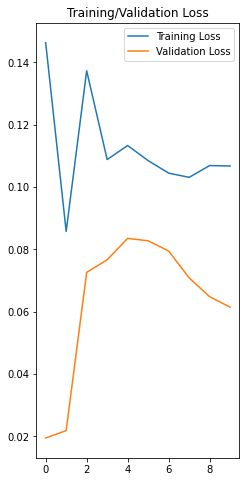

Epoch 1/10
102/102 [==============================] - 1s 9ms/step - loss: 0.0887 - mae: 0.0840 - rmse: 0.0885 - val_loss: 0.0334 - val_mae: 0.0300 - val_rmse: 0.0336
Epoch 2/10
102/102 [==============================] - 1s 8ms/step - loss: 0.1183 - mae: 0.1138 - rmse: 0.1178 - val_loss: 0.0324 - val_mae: 0.0297 - val_rmse: 0.0326
Epoch 3/10
102/102 [==============================] - 1s 8ms/step - loss: 0.1005 - mae: 0.0979 - rmse: 0.1000 - val_loss: 0.0401 - val_mae: 0.0375 - val_rmse: 0.0405
Epoch 4/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0877 - mae: 0.0849 - rmse: 0.0875 - val_loss: 0.0274 - val_mae: 0.0249 - val_rmse: 0.0274
Epoch 5/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0814 - mae: 0.0783 - rmse: 0.0810 - val_loss: 0.0357 - val_mae: 0.0332 - val_rmse: 0.0360

Epoch 00005: val_loss improved from 0.06145 to 0.03574, saving model to my_model_5_0.036.h5
Epoch 6/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0

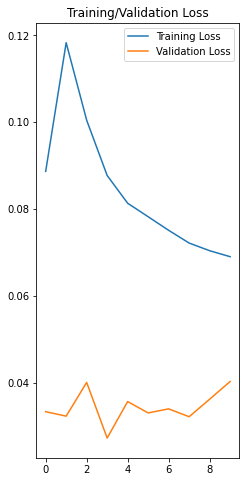

Epoch 1/10
152/152 [==============================] - 3s 7ms/step - loss: 0.0574 - mae: 0.0541 - rmse: 0.0574 - val_loss: 0.0769 - val_mae: 0.0673 - val_rmse: 0.0775
Epoch 2/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0464 - mae: 0.0417 - rmse: 0.0464 - val_loss: 0.0719 - val_mae: 0.0605 - val_rmse: 0.0726
Epoch 3/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0434 - mae: 0.0390 - rmse: 0.0434 - val_loss: 0.0827 - val_mae: 0.0729 - val_rmse: 0.0831
Epoch 4/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0467 - mae: 0.0424 - rmse: 0.0467 - val_loss: 0.0796 - val_mae: 0.0699 - val_rmse: 0.0800
Epoch 5/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0440 - mae: 0.0399 - rmse: 0.0440 - val_loss: 0.0756 - val_mae: 0.0650 - val_rmse: 0.0762

Epoch 00005: val_loss did not improve from 0.03574
Epoch 6/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0425 - mae: 0.0383 - rmse: 0.0425 - val_lo

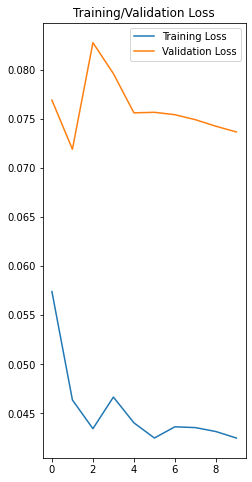

[array([[2497.0715, 2507.913 ]], dtype=float32), array([[2511.7822, 2523.7507]], dtype=float32), array([[2527.2866, 2540.1868]], dtype=float32), array([[2541.169 , 2554.4626]], dtype=float32), array([[2553.4766, 2567.022 ]], dtype=float32), array([[2565.025 , 2578.8574]], dtype=float32), array([[2576.6658, 2590.8423]], dtype=float32), array([[2588.3347, 2602.8596]], dtype=float32), array([[2599.445 , 2614.2202]], dtype=float32), array([[2609.9314, 2624.8894]], dtype=float32), array([[2619.715 , 2634.8005]], dtype=float32), array([[2628.8262, 2644.0015]], dtype=float32), array([[2637.2947, 2652.5315]], dtype=float32), array([[2645.1313, 2660.4065]], dtype=float32), array([[2652.3289, 2667.6191]], dtype=float32)]
[2497.0715, 2511.7822, 2527.2866, 2541.169, 2553.4766, 2565.025, 2576.6658, 2588.3347, 2599.445, 2609.9314, 2619.715, 2628.8262, 2637.2947, 2645.1313, 2652.3289]


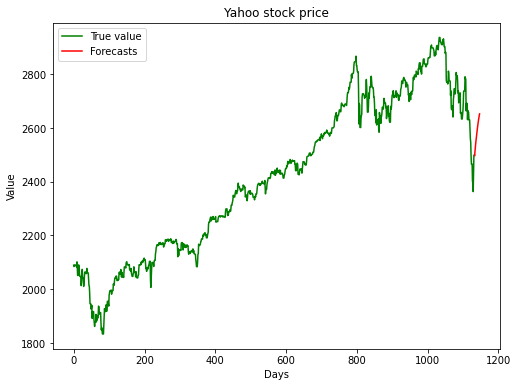

Epoch 1/50
51/51 [==============================] - 5s 25ms/step - loss: 0.3264 - mae: 0.3212 - rmse: 0.3264 - val_loss: 0.0211 - val_mae: 0.0179 - val_rmse: 0.0206
Epoch 2/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1496 - mae: 0.1415 - rmse: 0.1496 - val_loss: 0.0364 - val_mae: 0.0326 - val_rmse: 0.0367
Epoch 3/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1636 - mae: 0.1583 - rmse: 0.1636 - val_loss: 0.0905 - val_mae: 0.0898 - val_rmse: 0.0910
Epoch 4/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1123 - mae: 0.1068 - rmse: 0.1123 - val_loss: 0.0910 - val_mae: 0.0896 - val_rmse: 0.0914
Epoch 5/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1165 - mae: 0.1112 - rmse: 0.1165 - val_loss: 0.0929 - val_mae: 0.0917 - val_rmse: 0.0933

Epoch 00005: val_loss improved from inf to 0.09293, saving model to my_model_5_0.093.h5
Epoch 6/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1196 - mae: 0.11

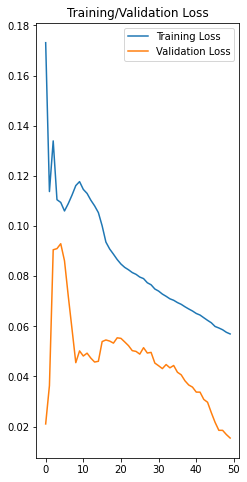

Epoch 1/50
102/102 [==============================] - 1s 10ms/step - loss: 0.0398 - mae: 0.0356 - rmse: 0.0397 - val_loss: 0.0231 - val_mae: 0.0194 - val_rmse: 0.0219
Epoch 2/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0486 - mae: 0.0446 - rmse: 0.0484 - val_loss: 0.0200 - val_mae: 0.0161 - val_rmse: 0.0203
Epoch 3/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0466 - mae: 0.0421 - rmse: 0.0464 - val_loss: 0.0289 - val_mae: 0.0236 - val_rmse: 0.0298
Epoch 4/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0442 - mae: 0.0395 - rmse: 0.0440 - val_loss: 0.0222 - val_mae: 0.0182 - val_rmse: 0.0225
Epoch 5/50
102/102 [==============================] - 1s 8ms/step - loss: 0.0432 - mae: 0.0386 - rmse: 0.0430 - val_loss: 0.0226 - val_mae: 0.0182 - val_rmse: 0.0235

Epoch 00005: val_loss did not improve from 0.01546
Epoch 6/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0449 - mae: 0.0406 - rmse: 0.0447 - val_l

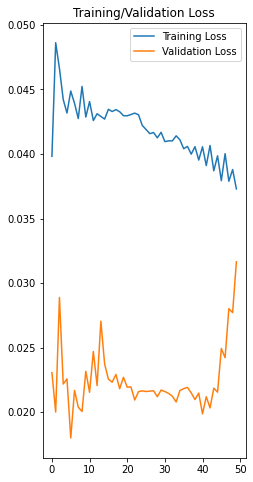

Epoch 1/50
152/152 [==============================] - 3s 8ms/step - loss: 0.0334 - mae: 0.0289 - rmse: 0.0334 - val_loss: 0.0749 - val_mae: 0.0663 - val_rmse: 0.0751
Epoch 2/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0317 - mae: 0.0272 - rmse: 0.0317 - val_loss: 0.0804 - val_mae: 0.0718 - val_rmse: 0.0805
Epoch 3/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0320 - mae: 0.0277 - rmse: 0.0320 - val_loss: 0.0803 - val_mae: 0.0721 - val_rmse: 0.0804
Epoch 4/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0330 - mae: 0.0288 - rmse: 0.0330 - val_loss: 0.0698 - val_mae: 0.0605 - val_rmse: 0.0702
Epoch 5/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0330 - mae: 0.0287 - rmse: 0.0330 - val_loss: 0.0724 - val_mae: 0.0635 - val_rmse: 0.0727

Epoch 00005: val_loss did not improve from 0.01546
Epoch 6/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0304 - mae: 0.0260 - rmse: 0.0304 - val_lo

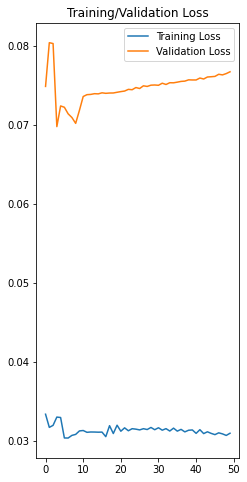

[array([[2509.9697, 2519.6685]], dtype=float32), array([[2536.4158, 2548.1416]], dtype=float32), array([[2561.1055, 2573.647 ]], dtype=float32), array([[2584.0273, 2596.913 ]], dtype=float32), array([[2604.0874, 2616.784 ]], dtype=float32), array([[2621.9558, 2633.9917]], dtype=float32), array([[2638.256 , 2649.3374]], dtype=float32), array([[2652.6145, 2662.639 ]], dtype=float32), array([[2664.5615, 2673.5674]], dtype=float32), array([[2674.1147, 2682.1094]], dtype=float32), array([[2681.545 , 2688.5564]], dtype=float32), array([[2687.241 , 2693.3508]], dtype=float32), array([[2691.5735, 2696.8962]], dtype=float32), array([[2694.831 , 2699.4944]], dtype=float32), array([[2697.242 , 2701.3713]], dtype=float32)]
[2509.9697, 2536.4158, 2561.1055, 2584.0273, 2604.0874, 2621.9558, 2638.256, 2652.6145, 2664.5615, 2674.1147, 2681.545, 2687.241, 2691.5735, 2694.831, 2697.242]


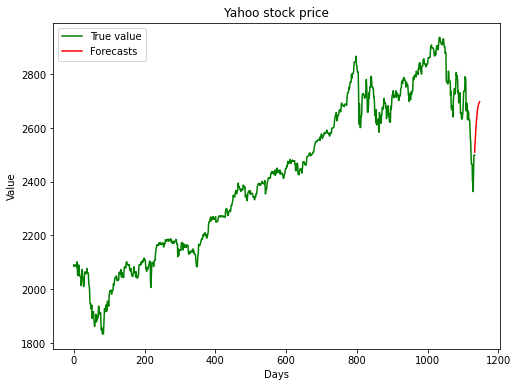

Epoch 1/100
51/51 [==============================] - 4s 25ms/step - loss: 0.3382 - mae: 0.3337 - rmse: 0.3381 - val_loss: 0.0104 - val_mae: 0.0089 - val_rmse: 0.0105
Epoch 2/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1467 - mae: 0.1389 - rmse: 0.1467 - val_loss: 0.0399 - val_mae: 0.0308 - val_rmse: 0.0404
Epoch 3/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1506 - mae: 0.1449 - rmse: 0.1506 - val_loss: 0.0921 - val_mae: 0.0904 - val_rmse: 0.0925
Epoch 4/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1069 - mae: 0.1008 - rmse: 0.1069 - val_loss: 0.0913 - val_mae: 0.0904 - val_rmse: 0.0917
Epoch 5/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1114 - mae: 0.1058 - rmse: 0.1114 - val_loss: 0.0917 - val_mae: 0.0909 - val_rmse: 0.0921

Epoch 00005: val_loss improved from inf to 0.09169, saving model to my_model_5_0.092.h5
Epoch 6/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1155 - mae

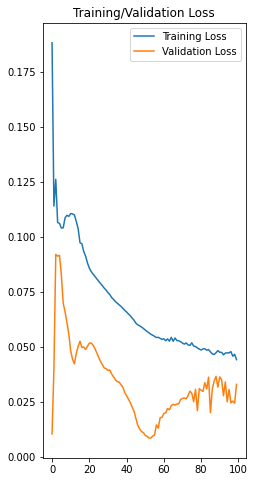

Epoch 1/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0418 - mae: 0.0364 - rmse: 0.0418 - val_loss: 0.0265 - val_mae: 0.0233 - val_rmse: 0.0253
Epoch 2/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0440 - mae: 0.0397 - rmse: 0.0439 - val_loss: 0.0206 - val_mae: 0.0170 - val_rmse: 0.0208
Epoch 3/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0431 - mae: 0.0385 - rmse: 0.0429 - val_loss: 0.0215 - val_mae: 0.0180 - val_rmse: 0.0219
Epoch 4/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0408 - mae: 0.0363 - rmse: 0.0407 - val_loss: 0.0215 - val_mae: 0.0179 - val_rmse: 0.0219
Epoch 5/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0391 - mae: 0.0345 - rmse: 0.0389 - val_loss: 0.0237 - val_mae: 0.0203 - val_rmse: 0.0243

Epoch 00005: val_loss did not improve from 0.00946
Epoch 6/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0384 - mae: 0.0336 - rmse: 0.0382 -

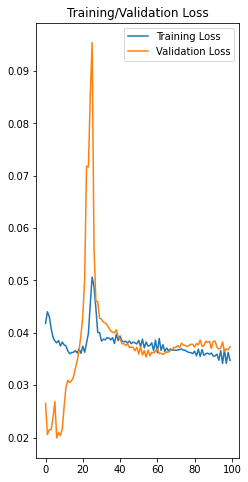

Epoch 1/100
152/152 [==============================] - 3s 8ms/step - loss: 0.0359 - mae: 0.0318 - rmse: 0.0359 - val_loss: 0.0694 - val_mae: 0.0603 - val_rmse: 0.0698
Epoch 2/100
152/152 [==============================] - 1s 7ms/step - loss: 0.0336 - mae: 0.0289 - rmse: 0.0336 - val_loss: 0.0688 - val_mae: 0.0592 - val_rmse: 0.0692
Epoch 3/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0375 - mae: 0.0329 - rmse: 0.0375 - val_loss: 0.0740 - val_mae: 0.0647 - val_rmse: 0.0742
Epoch 4/100
152/152 [==============================] - 1s 7ms/step - loss: 0.0322 - mae: 0.0280 - rmse: 0.0322 - val_loss: 0.0719 - val_mae: 0.0629 - val_rmse: 0.0722
Epoch 5/100
152/152 [==============================] - 1s 7ms/step - loss: 0.0304 - mae: 0.0259 - rmse: 0.0304 - val_loss: 0.0692 - val_mae: 0.0590 - val_rmse: 0.0695

Epoch 00005: val_loss did not improve from 0.00946
Epoch 6/100
152/152 [==============================] - 1s 7ms/step - loss: 0.0330 - mae: 0.0288 - rmse: 0.0330 - 

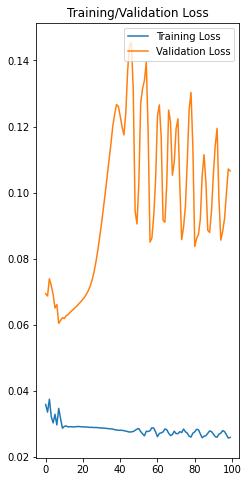

[array([[2482.2195, 2492.5583]], dtype=float32), array([[2489.3528, 2499.1064]], dtype=float32), array([[2498.539 , 2508.5112]], dtype=float32), array([[2507.5886, 2517.972 ]], dtype=float32), array([[2516.3647, 2527.1748]], dtype=float32), array([[2525.1848, 2536.2903]], dtype=float32), array([[2534.6528, 2545.9443]], dtype=float32), array([[2545.037 , 2556.5276]], dtype=float32), array([[2556.5183, 2568.2463]], dtype=float32), array([[2569.04  , 2581.0793]], dtype=float32), array([[2582.5388, 2594.9272]], dtype=float32), array([[2596.9429, 2609.68  ]], dtype=float32), array([[2612.0745, 2625.1196]], dtype=float32), array([[2627.5952, 2640.859 ]], dtype=float32), array([[2642.9797, 2656.304 ]], dtype=float32)]
[2482.2195, 2489.3528, 2498.539, 2507.5886, 2516.3647, 2525.1848, 2534.6528, 2545.037, 2556.5183, 2569.04, 2582.5388, 2596.9429, 2612.0745, 2627.5952, 2642.9797]


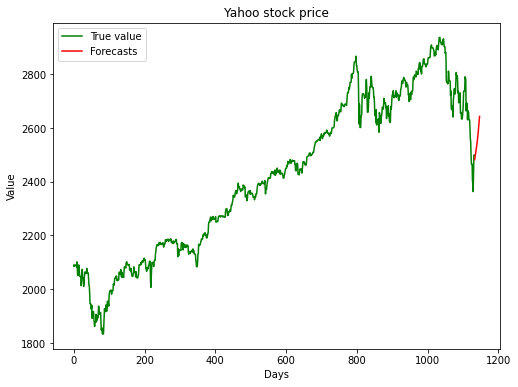

Epoch 1/60
51/51 [==============================] - 5s 26ms/step - loss: 0.2693 - mae: 0.2632 - rmse: 0.2692 - val_loss: 0.0236 - val_mae: 0.0226 - val_rmse: 0.0231
Epoch 2/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1193 - mae: 0.1136 - rmse: 0.1192 - val_loss: 0.0308 - val_mae: 0.0303 - val_rmse: 0.0303
Epoch 3/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1852 - mae: 0.1806 - rmse: 0.1852 - val_loss: 0.0831 - val_mae: 0.0782 - val_rmse: 0.0836
Epoch 4/60
51/51 [==============================] - 1s 10ms/step - loss: 0.1261 - mae: 0.1182 - rmse: 0.1261 - val_loss: 0.0874 - val_mae: 0.0858 - val_rmse: 0.0879
Epoch 5/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1209 - mae: 0.1145 - rmse: 0.1209 - val_loss: 0.0935 - val_mae: 0.0928 - val_rmse: 0.0939

Epoch 00005: val_loss improved from inf to 0.09347, saving model to my_model_5_0.093.h5
Epoch 6/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1195 - mae:

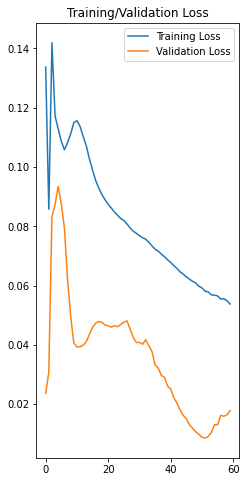

Epoch 1/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0399 - mae: 0.0354 - rmse: 0.0396 - val_loss: 0.0254 - val_mae: 0.0210 - val_rmse: 0.0266
Epoch 2/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0461 - mae: 0.0414 - rmse: 0.0458 - val_loss: 0.0189 - val_mae: 0.0151 - val_rmse: 0.0186
Epoch 3/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0462 - mae: 0.0421 - rmse: 0.0459 - val_loss: 0.0205 - val_mae: 0.0169 - val_rmse: 0.0211
Epoch 4/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0444 - mae: 0.0402 - rmse: 0.0441 - val_loss: 0.0257 - val_mae: 0.0213 - val_rmse: 0.0267
Epoch 5/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0416 - mae: 0.0372 - rmse: 0.0413 - val_loss: 0.0247 - val_mae: 0.0206 - val_rmse: 0.0257

Epoch 00005: val_loss did not improve from 0.00979
Epoch 6/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0418 - mae: 0.0374 - rmse: 0.0415 - 

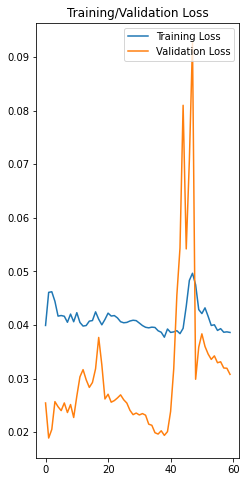

Epoch 1/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0366 - mae: 0.0325 - rmse: 0.0366 - val_loss: 0.1025 - val_mae: 0.0957 - val_rmse: 0.1023
Epoch 2/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0329 - mae: 0.0287 - rmse: 0.0329 - val_loss: 0.0754 - val_mae: 0.0669 - val_rmse: 0.0758
Epoch 3/60
152/152 [==============================] - 1s 10ms/step - loss: 0.0350 - mae: 0.0307 - rmse: 0.0350 - val_loss: 0.0824 - val_mae: 0.0736 - val_rmse: 0.0825
Epoch 4/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0325 - mae: 0.0286 - rmse: 0.0325 - val_loss: 0.0717 - val_mae: 0.0630 - val_rmse: 0.0721
Epoch 5/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0309 - mae: 0.0267 - rmse: 0.0309 - val_loss: 0.0721 - val_mae: 0.0634 - val_rmse: 0.0725

Epoch 00005: val_loss did not improve from 0.00979
Epoch 6/60
152/152 [==============================] - 1s 10ms/step - loss: 0.0303 - mae: 0.0261 - rmse: 0.0303 - 

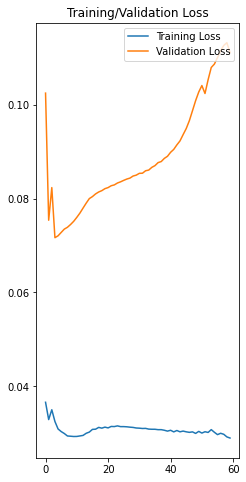

[array([[2483.6318, 2489.651 ]], dtype=float32), array([[2487.4768, 2492.501 ]], dtype=float32), array([[2492.6396, 2497.1223]], dtype=float32), array([[2498.8557, 2503.2563]], dtype=float32), array([[2505.3909, 2509.9626]], dtype=float32), array([[2511.5303, 2516.3665]], dtype=float32), array([[2517.3123, 2522.331 ]], dtype=float32), array([[2523.1326, 2528.2146]], dtype=float32), array([[2529.1467, 2534.2617]], dtype=float32), array([[2535.4932, 2540.6396]], dtype=float32), array([[2542.113, 2547.319]], dtype=float32), array([[2548.9844, 2554.269 ]], dtype=float32), array([[2556.0767, 2561.4534]], dtype=float32), array([[2563.3743, 2568.8518]], dtype=float32), array([[2570.8792, 2576.4626]], dtype=float32)]
[2483.6318, 2487.4768, 2492.6396, 2498.8557, 2505.3909, 2511.5303, 2517.3123, 2523.1326, 2529.1467, 2535.4932, 2542.113, 2548.9844, 2556.0767, 2563.3743, 2570.8792]


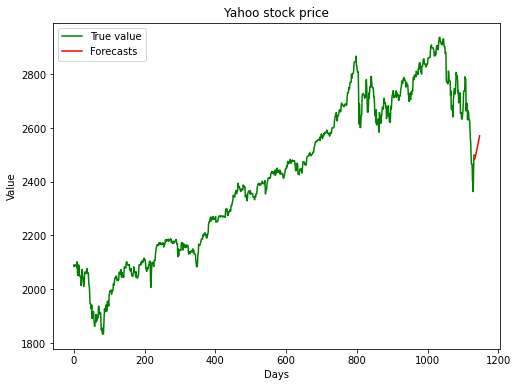

Epoch 1/90
51/51 [==============================] - 5s 34ms/step - loss: 0.2584 - mae: 0.2546 - rmse: 0.2584 - val_loss: 0.0214 - val_mae: 0.0206 - val_rmse: 0.0209
Epoch 2/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1321 - mae: 0.1284 - rmse: 0.1321 - val_loss: 0.0159 - val_mae: 0.0144 - val_rmse: 0.0163
Epoch 3/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1618 - mae: 0.1572 - rmse: 0.1618 - val_loss: 0.0830 - val_mae: 0.0820 - val_rmse: 0.0835
Epoch 4/90
51/51 [==============================] - 1s 12ms/step - loss: 0.1133 - mae: 0.1071 - rmse: 0.1133 - val_loss: 0.0793 - val_mae: 0.0783 - val_rmse: 0.0798
Epoch 5/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1157 - mae: 0.1096 - rmse: 0.1157 - val_loss: 0.0795 - val_mae: 0.0786 - val_rmse: 0.0800

Epoch 00005: val_loss improved from inf to 0.07949, saving model to my_model_5_0.079.h5
Epoch 6/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1183 - mae:

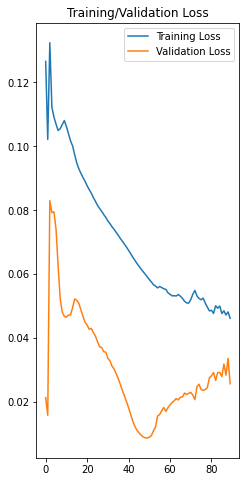

Epoch 1/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0414 - mae: 0.0357 - rmse: 0.0413 - val_loss: 0.0502 - val_mae: 0.0446 - val_rmse: 0.0539
Epoch 2/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0404 - mae: 0.0359 - rmse: 0.0401 - val_loss: 0.0416 - val_mae: 0.0377 - val_rmse: 0.0443
Epoch 3/90
102/102 [==============================] - 1s 10ms/step - loss: 0.0413 - mae: 0.0370 - rmse: 0.0410 - val_loss: 0.0464 - val_mae: 0.0424 - val_rmse: 0.0497
Epoch 4/90
102/102 [==============================] - 1s 10ms/step - loss: 0.0446 - mae: 0.0401 - rmse: 0.0443 - val_loss: 0.0462 - val_mae: 0.0422 - val_rmse: 0.0492
Epoch 5/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0425 - mae: 0.0381 - rmse: 0.0422 - val_loss: 0.0491 - val_mae: 0.0446 - val_rmse: 0.0523

Epoch 00005: val_loss did not improve from 0.00875
Epoch 6/90
102/102 [==============================] - 1s 10ms/step - loss: 0.0403 - mae: 0.0357 - rmse: 0.0401 - 

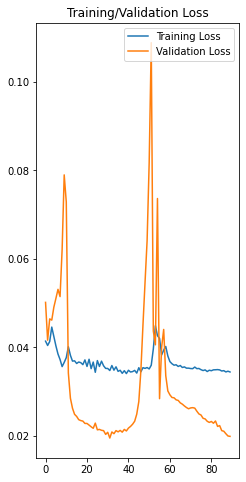

Epoch 1/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0299 - mae: 0.0254 - rmse: 0.0299 - val_loss: 0.0884 - val_mae: 0.0801 - val_rmse: 0.0883
Epoch 2/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0272 - mae: 0.0227 - rmse: 0.0272 - val_loss: 0.0768 - val_mae: 0.0680 - val_rmse: 0.0769
Epoch 3/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0296 - mae: 0.0254 - rmse: 0.0296 - val_loss: 0.0823 - val_mae: 0.0741 - val_rmse: 0.0823
Epoch 4/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0288 - mae: 0.0242 - rmse: 0.0288 - val_loss: 0.0710 - val_mae: 0.0617 - val_rmse: 0.0713
Epoch 5/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0268 - mae: 0.0223 - rmse: 0.0268 - val_loss: 0.0714 - val_mae: 0.0622 - val_rmse: 0.0717

Epoch 00005: val_loss did not improve from 0.00875
Epoch 6/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0254 - mae: 0.0209 - rmse: 0.0254 - 

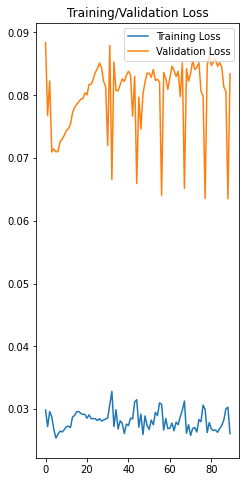

[array([[2479.0674, 2488.7131]], dtype=float32), array([[2481.2007, 2489.7935]], dtype=float32), array([[2484.9521, 2492.9233]], dtype=float32), array([[2489.6272, 2497.426 ]], dtype=float32), array([[2494.531 , 2502.4116]], dtype=float32), array([[2498.9143, 2507.0068]], dtype=float32), array([[2502.8875, 2511.1511]], dtype=float32), array([[2506.742 , 2515.0837]], dtype=float32), array([[2510.633 , 2518.9983]], dtype=float32), array([[2514.6833, 2523.0469]], dtype=float32), array([[2518.8247, 2527.1973]], dtype=float32), array([[2523.0276, 2531.4194]], dtype=float32), array([[2527.2651, 2535.6812]], dtype=float32), array([[2531.532, 2539.974]], dtype=float32), array([[2535.8337, 2544.2998]], dtype=float32)]
[2479.0674, 2481.2007, 2484.9521, 2489.6272, 2494.531, 2498.9143, 2502.8875, 2506.742, 2510.633, 2514.6833, 2518.8247, 2523.0276, 2527.2651, 2531.532, 2535.8337]


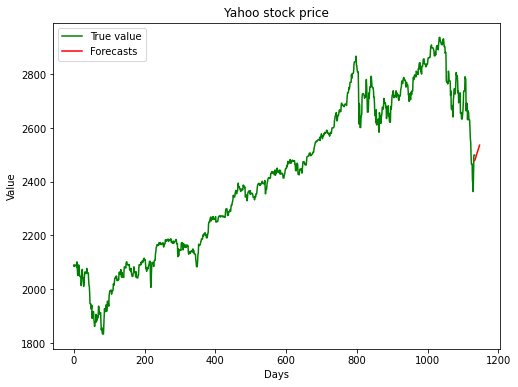

Epoch 1/120
51/51 [==============================] - 5s 28ms/step - loss: 0.2218 - mae: 0.2173 - rmse: 0.2218 - val_loss: 0.0270 - val_mae: 0.0220 - val_rmse: 0.0265
Epoch 2/120
51/51 [==============================] - 1s 10ms/step - loss: 0.1045 - mae: 0.0956 - rmse: 0.1045 - val_loss: 0.0303 - val_mae: 0.0288 - val_rmse: 0.0298
Epoch 3/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1619 - mae: 0.1533 - rmse: 0.1619 - val_loss: 0.0534 - val_mae: 0.0405 - val_rmse: 0.0538
Epoch 4/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1454 - mae: 0.1380 - rmse: 0.1454 - val_loss: 0.0819 - val_mae: 0.0809 - val_rmse: 0.0824
Epoch 5/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1186 - mae: 0.1134 - rmse: 0.1186 - val_loss: 0.0848 - val_mae: 0.0842 - val_rmse: 0.0853

Epoch 00005: val_loss improved from inf to 0.08482, saving model to my_model_5_0.085.h5
Epoch 6/120
51/51 [==============================] - 1s 12ms/step - loss: 0.1185 

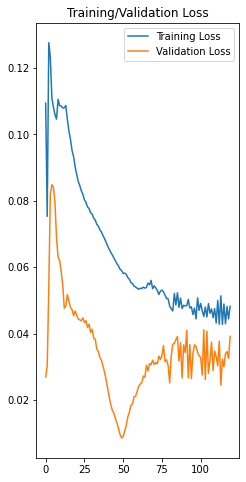

Epoch 1/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0434 - mae: 0.0382 - rmse: 0.0432 - val_loss: 0.0433 - val_mae: 0.0391 - val_rmse: 0.0456
Epoch 2/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0491 - mae: 0.0447 - rmse: 0.0487 - val_loss: 0.0221 - val_mae: 0.0187 - val_rmse: 0.0228
Epoch 3/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0481 - mae: 0.0428 - rmse: 0.0477 - val_loss: 0.0363 - val_mae: 0.0324 - val_rmse: 0.0382
Epoch 4/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0406 - mae: 0.0359 - rmse: 0.0403 - val_loss: 0.0436 - val_mae: 0.0386 - val_rmse: 0.0458
Epoch 5/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0378 - mae: 0.0324 - rmse: 0.0376 - val_loss: 0.0545 - val_mae: 0.0495 - val_rmse: 0.0571

Epoch 00005: val_loss did not improve from 0.00861
Epoch 6/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0368 - mae: 0.0315 - rmse: 0.0

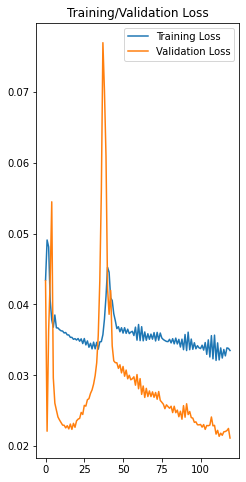

Epoch 1/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0310 - mae: 0.0266 - rmse: 0.0310 - val_loss: 0.0756 - val_mae: 0.0661 - val_rmse: 0.0757
Epoch 2/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0293 - mae: 0.0249 - rmse: 0.0293 - val_loss: 0.0700 - val_mae: 0.0605 - val_rmse: 0.0704
Epoch 3/120
152/152 [==============================] - 2s 10ms/step - loss: 0.0309 - mae: 0.0264 - rmse: 0.0309 - val_loss: 0.0757 - val_mae: 0.0670 - val_rmse: 0.0759
Epoch 4/120
152/152 [==============================] - 2s 10ms/step - loss: 0.0272 - mae: 0.0227 - rmse: 0.0272 - val_loss: 0.0749 - val_mae: 0.0662 - val_rmse: 0.0751
Epoch 5/120
152/152 [==============================] - 2s 10ms/step - loss: 0.0243 - mae: 0.0199 - rmse: 0.0243 - val_loss: 0.0770 - val_mae: 0.0684 - val_rmse: 0.0772

Epoch 00005: val_loss did not improve from 0.00861
Epoch 6/120
152/152 [==============================] - 2s 10ms/step - loss: 0.0268 - mae: 0.0223 - rmse: 0.0

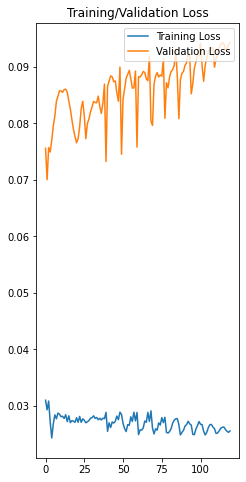

[array([[2470.2478, 2478.5562]], dtype=float32), array([[2467.9468, 2473.5266]], dtype=float32), array([[2466.711, 2471.782]], dtype=float32), array([[2465.8242, 2470.8997]], dtype=float32), array([[2464.278, 2469.518]], dtype=float32), array([[2462.2976, 2467.6934]], dtype=float32), array([[2460.1592, 2465.6487]], dtype=float32), array([[2458.1328, 2463.6355]], dtype=float32), array([[2456.2197, 2461.7166]], dtype=float32), array([[2454.433 , 2459.9287]], dtype=float32), array([[2452.7153, 2458.2249]], dtype=float32), array([[2451.062 , 2456.5918]], dtype=float32), array([[2449.482 , 2455.0332]], dtype=float32), array([[2447.985 , 2453.5574]], dtype=float32), array([[2446.576 , 2452.1685]], dtype=float32)]
[2470.2478, 2467.9468, 2466.711, 2465.8242, 2464.278, 2462.2976, 2460.1592, 2458.1328, 2456.2197, 2454.433, 2452.7153, 2451.062, 2449.482, 2447.985, 2446.576]


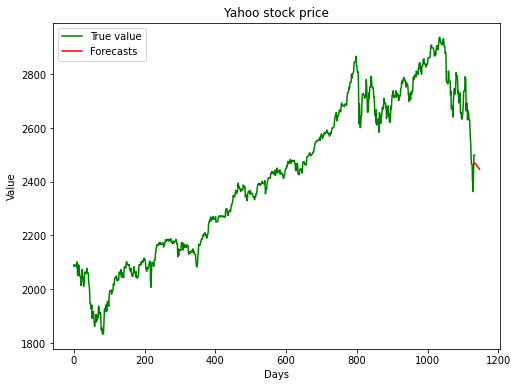

Epoch 1/50
32/32 [==============================] - 5s 40ms/step - loss: 0.3934 - mae: 0.3903 - rmse: 0.3933 - val_loss: 0.0421 - val_mae: 0.0400 - val_rmse: 0.0422
Epoch 2/50
32/32 [==============================] - 0s 14ms/step - loss: 0.1088 - mae: 0.1010 - rmse: 0.1088 - val_loss: 0.0390 - val_mae: 0.0353 - val_rmse: 0.0392
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.1169 - mae: 0.1098 - rmse: 0.1169 - val_loss: 0.0329 - val_mae: 0.0304 - val_rmse: 0.0339
Epoch 4/50
32/32 [==============================] - 0s 15ms/step - loss: 0.1284 - mae: 0.1226 - rmse: 0.1284 - val_loss: 0.0187 - val_mae: 0.0143 - val_rmse: 0.0217
Epoch 5/50
32/32 [==============================] - 0s 15ms/step - loss: 0.1464 - mae: 0.1412 - rmse: 0.1464 - val_loss: 0.0185 - val_mae: 0.0123 - val_rmse: 0.0226

Epoch 00005: val_loss improved from inf to 0.01854, saving model to my_model_5_0.019.h5
Epoch 6/50
32/32 [==============================] - 0s 14ms/step - loss: 0.1426 - mae:

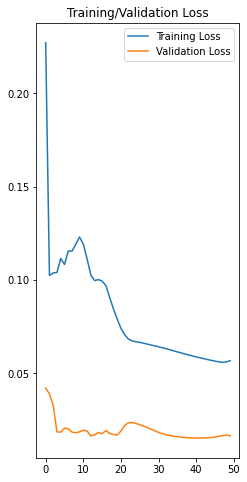

Epoch 1/50
64/64 [==============================] - 2s 26ms/step - loss: 0.0427 - mae: 0.0368 - rmse: 0.0428 - val_loss: 0.0393 - val_mae: 0.0336 - val_rmse: 0.0393
Epoch 2/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0441 - mae: 0.0383 - rmse: 0.0440 - val_loss: 0.0248 - val_mae: 0.0205 - val_rmse: 0.0248
Epoch 3/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0432 - mae: 0.0371 - rmse: 0.0431 - val_loss: 0.0279 - val_mae: 0.0236 - val_rmse: 0.0279
Epoch 4/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0433 - mae: 0.0368 - rmse: 0.0432 - val_loss: 0.0283 - val_mae: 0.0242 - val_rmse: 0.0283
Epoch 5/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0471 - mae: 0.0398 - rmse: 0.0470 - val_loss: 0.0265 - val_mae: 0.0215 - val_rmse: 0.0265

Epoch 00005: val_loss did not improve from 0.01543
Epoch 6/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0459 - mae: 0.0384 - rmse: 0.0457 - val_loss: 0.

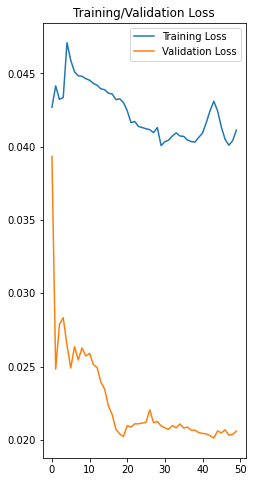

Epoch 1/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0360 - mae: 0.0305 - rmse: 0.0360 - val_loss: 0.0901 - val_mae: 0.0786 - val_rmse: 0.0910
Epoch 2/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0413 - mae: 0.0356 - rmse: 0.0413 - val_loss: 0.0755 - val_mae: 0.0626 - val_rmse: 0.0785
Epoch 3/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0461 - mae: 0.0405 - rmse: 0.0461 - val_loss: 0.0760 - val_mae: 0.0634 - val_rmse: 0.0788
Epoch 4/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0356 - mae: 0.0300 - rmse: 0.0355 - val_loss: 0.0751 - val_mae: 0.0612 - val_rmse: 0.0787
Epoch 5/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0322 - mae: 0.0266 - rmse: 0.0321 - val_loss: 0.0879 - val_mae: 0.0757 - val_rmse: 0.0891

Epoch 00005: val_loss did not improve from 0.01543
Epoch 6/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0400 - mae: 0.0350 - rmse: 0.0399 - val_loss: 0.

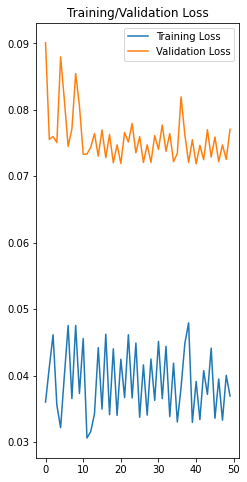

[array([[2496.112, 2507.555]], dtype=float32), array([[2509.6648, 2522.5208]], dtype=float32), array([[2522.3218, 2535.4746]], dtype=float32), array([[2534.2288, 2547.1545]], dtype=float32), array([[2545.8306, 2558.4253]], dtype=float32), array([[2557.043, 2569.34 ]], dtype=float32), array([[2567.4553, 2579.5535]], dtype=float32), array([[2577.2727, 2589.096 ]], dtype=float32), array([[2586.7046, 2598.1545]], dtype=float32), array([[2595.8164, 2606.849 ]], dtype=float32), array([[2604.5603, 2615.1711]], dtype=float32), array([[2612.8376, 2623.0398]], dtype=float32), array([[2620.6384, 2630.4219]], dtype=float32), array([[2627.9656, 2637.3196]], dtype=float32), array([[2634.827 , 2643.7476]], dtype=float32)]
[2496.112, 2509.6648, 2522.3218, 2534.2288, 2545.8306, 2557.043, 2567.4553, 2577.2727, 2586.7046, 2595.8164, 2604.5603, 2612.8376, 2620.6384, 2627.9656, 2634.827]


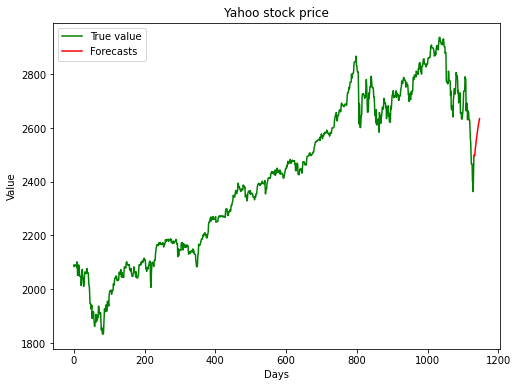

Epoch 1/90
32/32 [==============================] - 5s 42ms/step - loss: 0.3784 - mae: 0.3673 - rmse: 0.3783 - val_loss: 0.0710 - val_mae: 0.0579 - val_rmse: 0.0694
Epoch 2/90
32/32 [==============================] - 0s 14ms/step - loss: 0.1107 - mae: 0.1030 - rmse: 0.1107 - val_loss: 0.0436 - val_mae: 0.0424 - val_rmse: 0.0438
Epoch 3/90
32/32 [==============================] - 0s 14ms/step - loss: 0.1137 - mae: 0.1065 - rmse: 0.1136 - val_loss: 0.0341 - val_mae: 0.0308 - val_rmse: 0.0347
Epoch 4/90
32/32 [==============================] - 0s 14ms/step - loss: 0.1263 - mae: 0.1199 - rmse: 0.1262 - val_loss: 0.0163 - val_mae: 0.0120 - val_rmse: 0.0199
Epoch 5/90
32/32 [==============================] - 0s 14ms/step - loss: 0.1451 - mae: 0.1397 - rmse: 0.1450 - val_loss: 0.0153 - val_mae: 0.0099 - val_rmse: 0.0195

Epoch 00005: val_loss improved from inf to 0.01529, saving model to my_model_5_0.015.h5
Epoch 6/90
32/32 [==============================] - 0s 14ms/step - loss: 0.1483 - mae:

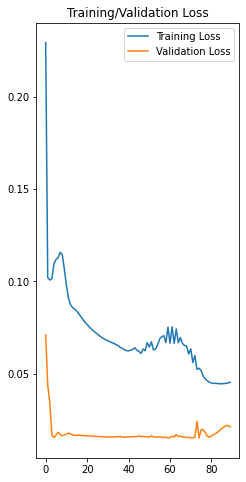

Epoch 1/90
64/64 [==============================] - 2s 26ms/step - loss: 0.0418 - mae: 0.0355 - rmse: 0.0421 - val_loss: 0.0584 - val_mae: 0.0555 - val_rmse: 0.0584
Epoch 2/90
64/64 [==============================] - 1s 13ms/step - loss: 0.0417 - mae: 0.0353 - rmse: 0.0415 - val_loss: 0.0238 - val_mae: 0.0196 - val_rmse: 0.0238
Epoch 3/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0398 - mae: 0.0334 - rmse: 0.0396 - val_loss: 0.0277 - val_mae: 0.0230 - val_rmse: 0.0277
Epoch 4/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0400 - mae: 0.0331 - rmse: 0.0398 - val_loss: 0.0284 - val_mae: 0.0235 - val_rmse: 0.0284
Epoch 5/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0408 - mae: 0.0337 - rmse: 0.0407 - val_loss: 0.0319 - val_mae: 0.0284 - val_rmse: 0.0319

Epoch 00005: val_loss did not improve from 0.01503
Epoch 6/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0433 - mae: 0.0358 - rmse: 0.0431 - val_loss: 0.

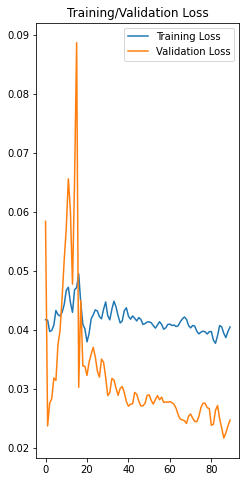

Epoch 1/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0371 - mae: 0.0316 - rmse: 0.0372 - val_loss: 0.0792 - val_mae: 0.0661 - val_rmse: 0.0826
Epoch 2/90
95/95 [==============================] - 1s 13ms/step - loss: 0.0370 - mae: 0.0313 - rmse: 0.0370 - val_loss: 0.0808 - val_mae: 0.0692 - val_rmse: 0.0837
Epoch 3/90
95/95 [==============================] - 1s 13ms/step - loss: 0.0322 - mae: 0.0266 - rmse: 0.0321 - val_loss: 0.0820 - val_mae: 0.0706 - val_rmse: 0.0847
Epoch 4/90
95/95 [==============================] - 1s 13ms/step - loss: 0.0318 - mae: 0.0263 - rmse: 0.0318 - val_loss: 0.0922 - val_mae: 0.0810 - val_rmse: 0.0933
Epoch 5/90
95/95 [==============================] - 1s 13ms/step - loss: 0.0351 - mae: 0.0301 - rmse: 0.0351 - val_loss: 0.0863 - val_mae: 0.0759 - val_rmse: 0.0881

Epoch 00005: val_loss did not improve from 0.01503
Epoch 6/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0444 - mae: 0.0388 - rmse: 0.0443 - val_loss: 0.

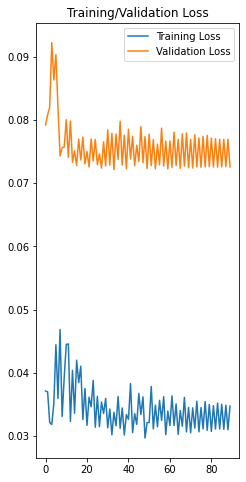

[array([[2453.67 , 2465.702]], dtype=float32), array([[2444.5107, 2453.0403]], dtype=float32), array([[2437.7559, 2445.143 ]], dtype=float32), array([[2432.9966, 2440.2737]], dtype=float32), array([[2428.44  , 2435.5193]], dtype=float32), array([[2423.4297, 2430.2563]], dtype=float32), array([[2417.9414, 2424.626 ]], dtype=float32), array([[2411.9963, 2418.6345]], dtype=float32), array([[2405.7678, 2412.3699]], dtype=float32), array([[2399.453 , 2405.9858]], dtype=float32), array([[2393.152, 2399.59 ]], dtype=float32), array([[2387.0454, 2393.334 ]], dtype=float32), array([[2381.046 , 2387.1897]], dtype=float32), array([[2375.1262, 2381.129 ]], dtype=float32), array([[2369.2695, 2375.1326]], dtype=float32)]
[2453.67, 2444.5107, 2437.7559, 2432.9966, 2428.44, 2423.4297, 2417.9414, 2411.9963, 2405.7678, 2399.453, 2393.152, 2387.0454, 2381.046, 2375.1262, 2369.2695]


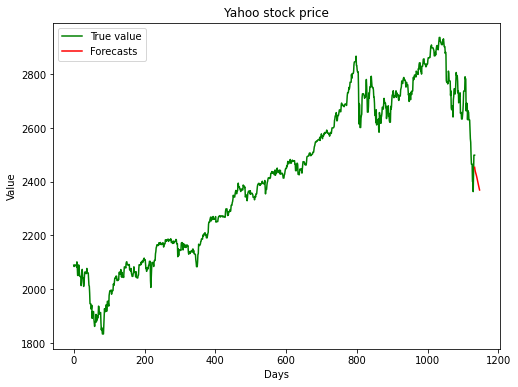

Epoch 1/120
32/32 [==============================] - 5s 42ms/step - loss: 0.3748 - mae: 0.3686 - rmse: 0.3747 - val_loss: 0.0383 - val_mae: 0.0333 - val_rmse: 0.0416
Epoch 2/120
32/32 [==============================] - 0s 16ms/step - loss: 0.1354 - mae: 0.1235 - rmse: 0.1354 - val_loss: 0.0297 - val_mae: 0.0267 - val_rmse: 0.0310
Epoch 3/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1131 - mae: 0.1043 - rmse: 0.1131 - val_loss: 0.0205 - val_mae: 0.0162 - val_rmse: 0.0231
Epoch 4/120
32/32 [==============================] - 1s 16ms/step - loss: 0.1240 - mae: 0.1175 - rmse: 0.1240 - val_loss: 0.0151 - val_mae: 0.0100 - val_rmse: 0.0192
Epoch 5/120
32/32 [==============================] - 0s 16ms/step - loss: 0.1310 - mae: 0.1249 - rmse: 0.1310 - val_loss: 0.0152 - val_mae: 0.0099 - val_rmse: 0.0194

Epoch 00005: val_loss improved from inf to 0.01521, saving model to my_model_5_0.015.h5
Epoch 6/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1314 

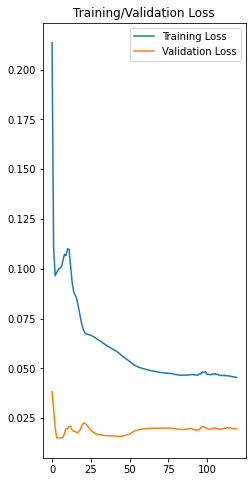

Epoch 1/120
64/64 [==============================] - 2s 28ms/step - loss: 0.0378 - mae: 0.0315 - rmse: 0.0378 - val_loss: 0.0246 - val_mae: 0.0200 - val_rmse: 0.0246
Epoch 2/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0396 - mae: 0.0330 - rmse: 0.0395 - val_loss: 0.0235 - val_mae: 0.0193 - val_rmse: 0.0235
Epoch 3/120
64/64 [==============================] - 1s 13ms/step - loss: 0.0418 - mae: 0.0350 - rmse: 0.0416 - val_loss: 0.0214 - val_mae: 0.0170 - val_rmse: 0.0214
Epoch 4/120
64/64 [==============================] - 1s 13ms/step - loss: 0.0413 - mae: 0.0344 - rmse: 0.0411 - val_loss: 0.0223 - val_mae: 0.0179 - val_rmse: 0.0223
Epoch 5/120
64/64 [==============================] - 1s 13ms/step - loss: 0.0421 - mae: 0.0353 - rmse: 0.0419 - val_loss: 0.0213 - val_mae: 0.0171 - val_rmse: 0.0213

Epoch 00005: val_loss did not improve from 0.01521
Epoch 6/120
64/64 [==============================] - 1s 13ms/step - loss: 0.0432 - mae: 0.0364 - rmse: 0.0430 - val_lo

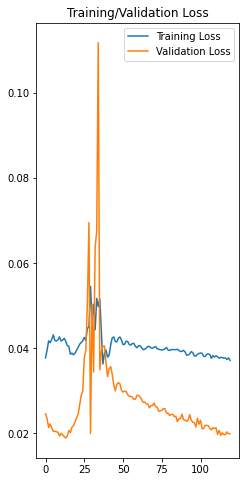

Epoch 1/120
95/95 [==============================] - 1s 15ms/step - loss: 0.0328 - mae: 0.0274 - rmse: 0.0327 - val_loss: 0.1181 - val_mae: 0.1084 - val_rmse: 0.1169
Epoch 2/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0363 - mae: 0.0307 - rmse: 0.0362 - val_loss: 0.0832 - val_mae: 0.0713 - val_rmse: 0.0856
Epoch 3/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0392 - mae: 0.0335 - rmse: 0.0391 - val_loss: 0.1057 - val_mae: 0.0949 - val_rmse: 0.1055
Epoch 4/120
95/95 [==============================] - 1s 13ms/step - loss: 0.0362 - mae: 0.0308 - rmse: 0.0361 - val_loss: 0.0942 - val_mae: 0.0846 - val_rmse: 0.0953
Epoch 5/120
95/95 [==============================] - 1s 13ms/step - loss: 0.0378 - mae: 0.0320 - rmse: 0.0377 - val_loss: 0.0931 - val_mae: 0.0816 - val_rmse: 0.0939

Epoch 00005: val_loss did not improve from 0.01521
Epoch 6/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0424 - mae: 0.0373 - rmse: 0.0423 - val_lo

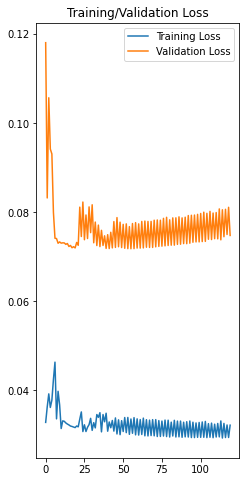

[array([[2458.0366, 2467.3933]], dtype=float32), array([[2447.701 , 2453.6582]], dtype=float32), array([[2440.5488, 2445.6497]], dtype=float32), array([[2435.5679, 2440.5835]], dtype=float32), array([[2431.0627, 2436.092 ]], dtype=float32), array([[2426.4653, 2431.5264]], dtype=float32), array([[2421.6082, 2426.6982]], dtype=float32), array([[2416.5247, 2421.6243]], dtype=float32), array([[2411.3792, 2416.449 ]], dtype=float32), array([[2406.2952, 2411.3071]], dtype=float32), array([[2401.378 , 2406.3123]], dtype=float32), array([[2396.628, 2401.49 ]], dtype=float32), array([[2391.9917, 2396.7969]], dtype=float32), array([[2387.4414, 2392.1965]], dtype=float32), array([[2382.9592, 2387.667 ]], dtype=float32)]
[2458.0366, 2447.701, 2440.5488, 2435.5679, 2431.0627, 2426.4653, 2421.6082, 2416.5247, 2411.3792, 2406.2952, 2401.378, 2396.628, 2391.9917, 2387.4414, 2382.9592]


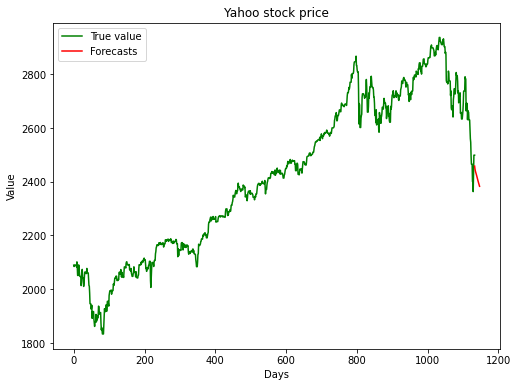

In [17]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [18]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [19]:
for f in final_dict:
  print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
  print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.08054136335849761, 0.07629767544567585, 0.08038563293715319, 0.05797095485031605, 0.05287030140558879, 0.05830126497894526] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.053227105612556135, 0.048792095395425956, 0.05312472123652697, 0.047838955540210004, 0.043056037935117884, 0.04829136535525322] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.04494950955112775, 0.04027155649537842, 0.04489573445791999, 0.05619386700602869, 0.05202729922719299, 0.056453696625928085] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.0512064058954517, 0.04668555261774195, 0.05105306902486417, 0.05198603304516938, 0.04755459703091117, 0.05246734587061736] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.045075944590347784, 0.04034051932394504, 0.04494887265480227, 0.04742816445176248, 0.042741490217

In [20]:
final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.080541,0.076298,0.080386,0.057971,0.052870,0.058301
2,0.053227,0.048792,0.053125,0.047839,0.043056,0.048291
3,0.044950,0.040272,0.044896,0.056194,0.052027,0.056454
4,0.051206,0.046686,0.051053,0.051986,0.047555,0.052467
5,0.045076,0.040341,0.044949,0.047428,0.042741,0.047740
6,0.042532,0.037686,0.042428,0.049764,0.045647,0.049774
7,0.054304,0.048099,0.054092,0.039228,0.031573,0.041310
8,0.048978,0.042729,0.048746,0.041788,0.034534,0.043949
9,0.044419,0.038030,0.044208,0.041061,0.033513,0.043198


In [23]:
final_df.to_csv(r"resultados",index=True)